<a href="https://colab.research.google.com/github/kkimyunjoo/24-2-ESAA/blob/main/0909_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **핸즈온 Ch.7 앙상블 학습과 랜덤 포레스트**

p.245- 271

**[7.1 투표 기반 분류기]**
- 직접 투표 분류기: 다수결 투표로 정해지는 분류기
  - 각 분류기가 약한 학습기여도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음. : 큰 수의 법칙

In [19]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

# 5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [21]:
#각 분류기의 테스트셋 정확도 확인하기
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.95


-> 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음. : 간접 투표

**[7.2 배깅과 페이스팅]**
- 배깅: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅: 중복을 허용하지 않고 샘플링하는 방식

-> 배깅과 페이스팅 모두 같은 훈련 샘플을 여러개의 예측기에 걸쳐서 사용할 수 있음. 배깅만 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음.

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듬.
  - 수집 함수: 통계적 최빈값(분류), 평균(회귀)
  - 앙상블의 결과; 일반적으로 편향은 비슷하지만 분산은 줄어듬.


7.2.1 사이킷런의 배깅과 페이스팅
- BaggingClssifier
  - 페이스팅 사용: bootstrap=False 지정

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)   #배깅 : bootstrap = True / 페이스팅 : False
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 단일 결정 트리와 배깅 앙상블 결과 비교
  - 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨.
  - 비슷한 편향에서 더 작은 분산 만듬.
  - 부트스트래핑: 각 예측기가 학습하는 서브셋에 다양성을 증가시킴.

    -> 배깅이 페이스팅보다 편향이 조금 더 높음, 분산은 더 감소

    -> 전반적으로 배깅이 더 나은 모델 만들기 때문에 일반적으로 더 선호함.

7.2.2. obb 평가
- obb 샘플: 배깅 테스팅 중 선택되지 않은 훈련 샘플의 나머지
- obb_score=True로 지정하면 훈련이 끝난 후 자동으로 obb 평가 수행

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9375

In [24]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.95

In [25]:
#obb 샘플에 대한 결정 함수 값
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.31213873, 0.68786127],
       [0.97297297, 0.02702703],
       [1.        , 0.        ],
       [0.96470588, 0.03529412],
       [0.16201117, 0.83798883],
       [0.05027933, 0.94972067],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.0441989 , 0.9558011 ],
       [0.9947644 , 0.0052356 ],
       [0.99456522, 0.00543478],
       [0.85207101, 0.14792899],
       [0.07978723, 0.92021277],
       [1.        , 0.        ],
       [0.265625  , 0.734375  ],
       [0.        , 1.        ],
       [0.29577465, 0.70422535],
       [0.94444444, 0.05555556],
       [0.30107527, 0.69892473],
       [0.96835443, 0.03164557],
       [1.        , 0.        ],
       [0.155     , 0.845     ],
       [0.03314917, 0.96685083],
       [0.        , 1.        ],
       [0.11827957, 0.88172043],
       [0.01546392, 0.98453608],
       [0.82722513, 0.17277487],
       [0.

**[7.3 랜덤 패치와 랜덤 서브스페이스]**
- 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

**[7.4 랜덤 포레스트]**
- 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
- max_samples: 훈련 세트의 크기로 지정
- BaggingClassifier에 DecisionClassifier 넣는 대신 RandomForestClassifier 사용

In [26]:
#500개 트리로 이뤄진 랜덤 포ㅔ스트 분류기를 여러 CPU 코어에서 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes=16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함

  -> 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄.

In [27]:
#BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "auto", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

7.4.1 엑스트라 트리
- 익스트림 랜덤 트리(엑스트라 트리): 극단적으로 무작위한 트리의 랜덤 포레스트
  - 편향은 늘어나지만 분산은 낮춤.
  - 일반적인 랜덤 포레스트보다 더 빠름
  - ExtraTreeClassifier

7.4.2 특성 중요도
- 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정 -> 가중치 평균, 각 노드의 가중치는 연관된 훈련 샘플 수와 동일
- 사이킷런은 훈련이 끝나고 각 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값을 정규화 후 feature_importances 에 저장함.

In [28]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.09348732731767148
sepal width (cm) 0.022312890738898052
petal length (cm) 0.44843144998495443
petal width (cm) 0.435768331958476


**[7.5 부스팅]**
- 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

7.5.1 에이다부스트
- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높여 이전 예측기를 보완하는 방법 -> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰짐.
- 모든 예측기가 훈련을 맞치면 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨.
- 사이킷런: SAMME 라는 에이다부스트의 다중 클래스 버전 사용

In [29]:
#AdaBoosetClassifier의 기본 추정기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = 0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

7.5.2 그레이디언트 부스팅
- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가(에이다부스트와 동일), 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴.

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [31]:
#두 번째 예측기가 만든 잔여 오창[ 세번째 회귀 모델을 훈련시키기
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [32]:
#모든 트리의 예측을 더하기 -> 새로운 샘플에 대한 예측
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=2, learning_rate = 1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

- learning_rate: 각 트리의 기여 정도 조절
  - 0.1과 같이 낮게 설정: 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐(축소)
- staged_predict() : 최적의 트리 수를 찾기 위한 조기 종료 기법

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=39)

- warm_start=True : 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌.

In [35]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up +=1
    if error_going_up == 5:
      break # 조기 종료

- subsample: 사용할 훈련 샘플의 비율 지정, 편향이 높아지는 대신 분산이 낮아짐. -> 확률적 그레이디언트 부스팅

In [36]:
#xgboost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

In [37]:
#자동 조기 종료
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

**[7.6 스태킹]**
- 3개의 예측기가 예측한 각각 다른 값을 마지막 예측기(블렌더 또는 메타 학습기)가 입력으로 받아 최종 예측 생성
- 블렌더 학습: 홀드 아웃 세트 사용
- 사이킷런은 스태킹은 직접 지원하지는 않음.

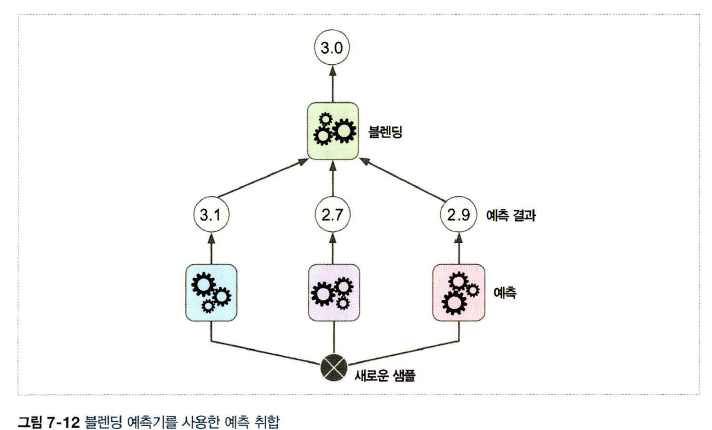